<img src="logo.png" align="left"><br><br><br><br><br>

# Demonstration of Reproducibility and Transparency in Responsible AI
## Persona: Data Scientist

Author: Dattaraj Rao (dattaraj_rao@pesistent.com) <br>
https://www.linkedin.com/in/dattarajrao/ 

<img src="ds_cycle.png" width="600" background="black"/>

# Load dataset from Data Catalog 

Dataset source: https://www.kaggle.com/leonbora/analytics-vidhya-loan-prediction

In [20]:
# Code to load dataset using DVC
'''
import dvc.api
import pandas as pd
from io import StringIO  

#version 1 = HEAD~4, verson 2 = HEAD~3
dataset_revision = 'HEAD~5' # v1
dataset_name = 'dataset-v1'

dataset = dvc.api.read(
    'bfsi/LoanApproval.csv',
    repo='Your DVC Repo',
    rev=dataset_revision,
    mode='r')

df = pd.read_csv(StringIO(dataset))
df.head()
'''

"\nimport dvc.api\nimport pandas as pd\nfrom io import StringIO  \n\n#version 1 = HEAD~4, verson 2 = HEAD~3\ndataset_revision = 'HEAD~5' # v1\ndataset_name = 'dataset-v1'\n\ndataset = dvc.api.read(\n    'bfsi/LoanApproval.csv',\n    repo='Your DVC Repo',\n    rev=dataset_revision,\n    mode='r')\n\ndf = pd.read_csv(StringIO(dataset))\ndf.head()\n"

### For standalone analysis without Data Catalog we will use named CSV files

In [21]:
import pandas as pd

# version 1 = loan_approval_dataset_v1.csv
# verson 2 = loan_approval_dataset_v2.csv
dataset_file = 'loan_approval_dataset_v1.csv' # v1
dataset_name = 'dataset-v1'

df = pd.read_csv(dataset_file)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Check the data distribution for Gender and Married

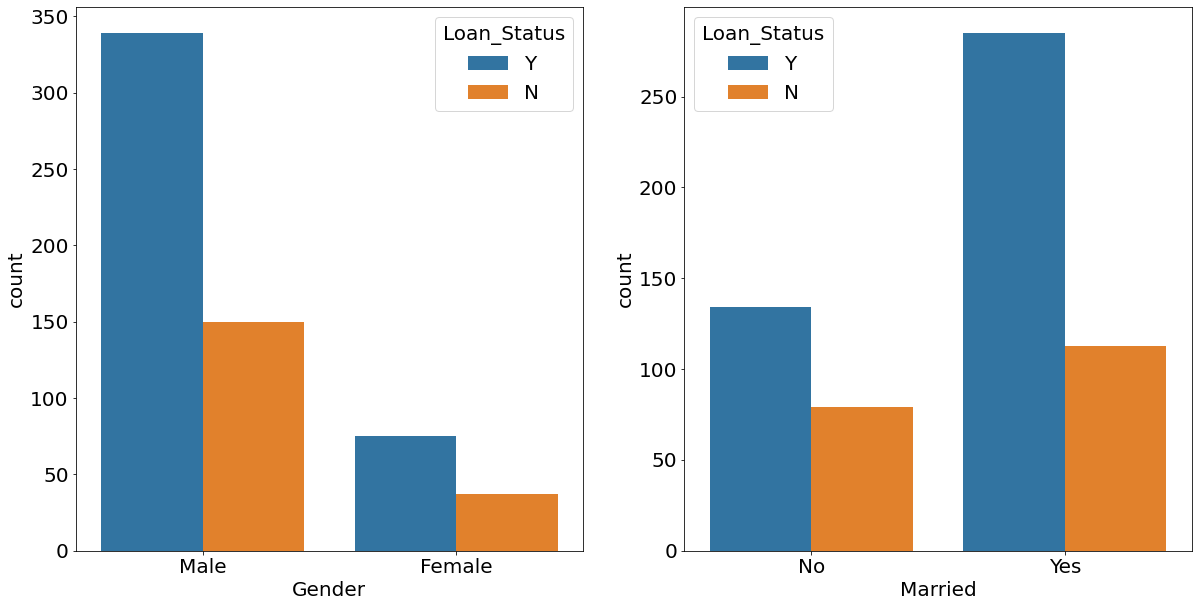

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## bar chart
plt.rcParams['font.size'] = '20'
categorical_columns = ['Gender', 'Married']
fig,axes = plt.subplots(1,2,figsize=(20,10))
for idx,cat_col in enumerate(categorical_columns):
    sns.countplot(x=cat_col, data=df, hue='Loan_Status', ax=axes[idx])
plt.subplots_adjust(hspace=0.5)

## Calculate fairness metrics

In [23]:
from aif360.sklearn.metrics import *

df_temp = df.copy()
df_temp.loc[df.Gender == 'Male', 'Gender'] = 1
df_temp.loc[df.Gender == 'Female', 'Gender'] = 0
df_temp.loc[df.Loan_Status == 'Y', 'Loan_Status'] = 1
df_temp.loc[df.Loan_Status == 'N', 'Loan_Status'] = 0
df_temp.set_index(['Gender'], inplace=True)

print('Statistical parity difference for Gender = ', statistical_parity_difference(df_temp[['Loan_Status']]))
print('Disparate impact ratio for Gender = ', disparate_impact_ratio(df_temp['Loan_Status']))

Statistical parity difference for Gender =  -0.029251533742331248
Disparate impact ratio for Gender =  0.9578053097345133


# Connect to MLFlow to log the experiment runs

MLFlow setup instructions are here: https://www.mlflow.org/docs/latest/tracking.html

In [24]:
import mlflow

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("bfsi-loanprediction")
mlflow.start_run(run_name=dataset_name)
mlflow.log_param('dataset', dataset_name)

# Log the charts

In [25]:
fig.savefig('DATA_DISTRIBUTION.png', bbox_inches='tight')
mlflow.log_artifact('DATA_DISTRIBUTION.png')

## Log fairness metrics

In [26]:
mlflow.log_metric('Statistical parity difference', statistical_parity_difference(df_temp[['Loan_Status']]))
mlflow.log_metric('Disparate impact ratio', disparate_impact_ratio(df_temp['Loan_Status']))

# Pre-processing & Feature Engineering

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

df_w = df.copy()
df_w = df.dropna()

df_w = df_w.drop(columns=['Loan_ID']) ## Dropping Loan ID
train_df_encoded = pd.get_dummies(df_w,drop_first=True)
X = train_df_encoded.drop(columns='Loan_Status_Y')
y = train_df_encoded['Loan_Status_Y']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)

imp = SimpleImputer(strategy='mean')
imp_train = imp.fit(X_train)
X_train = imp_train.transform(X_train)
X_test_tmp = X_test.copy()
X_test = imp_train.transform(X_test)

# Build the ML model

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

model = RandomForestClassifier(n_estimators=50,max_depth=3)
model.fit(X_train,y_train)
# cross-validation
xval_scores = cross_val_score(model, X_train, y_train, cv=10)

# Log metrics

<Figure size 2160x1080 with 0 Axes>

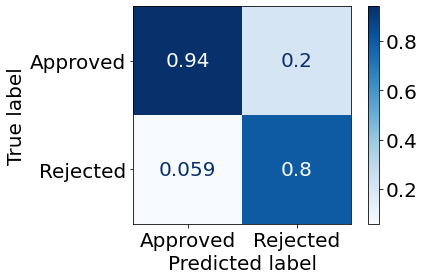

In [29]:
y_pred = model.predict(X_train)
train_f1 = f1_score(y_train,y_pred)
train_acc = accuracy_score(y_train,y_pred)
y_pred = model.predict(X_test)
test_f1 = f1_score(y_test,y_pred)
test_acc = accuracy_score(y_test,y_pred)

plt.figure(figsize=(30,15))
plot_confusion_matrix(model, X_test, y_test,
                     display_labels=['Approved', 'Rejected'],
                     cmap=plt.cm.Blues,
                     normalize='pred')
plt.savefig('CONFUSION_MATRIX.png', bbox_inches='tight')

In [30]:
mlflow.log_metric("test f1 score", test_f1)
mlflow.log_metric("test accuracy", test_acc)
mlflow.log_artifact('CONFUSION_MATRIX.png')

# Generate explanations

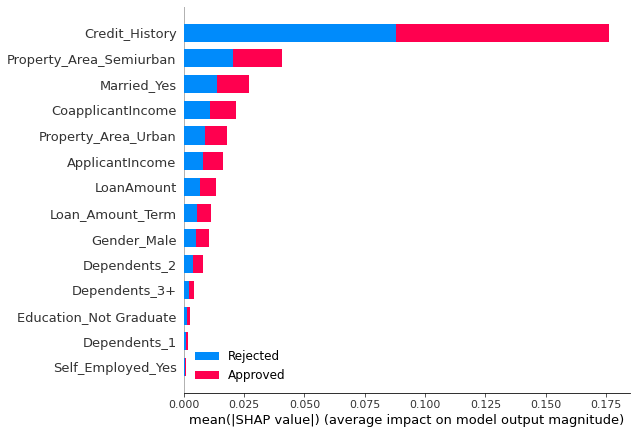

In [31]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(30,15))
shap.summary_plot(shap_values, X_test_tmp, show=False, class_names=['Rejected','Approved'])
plt.savefig('SHAP_EXPLANATIONS.png', bbox_inches='tight')

# Log the model & explanations

In [32]:
mlflow.log_artifact('SHAP_EXPLANATIONS.png')
mlflow.sklearn.log_model(model, "loan-model")

# End the run

In [33]:
mlflow.end_run()

# Optional: Save model to DVC Model Catalog

In [ ]:
import joblib
joblib.dump(model, "models/random-forest-v1.sav")

!dvc add models/random-forest-v1.sav
!git add models/random-forest-v1.sav.dvc models/.gitignore
!dvc push

# Load model from registry and predict

In [36]:
import mlflow.pyfunc

model_name = "Loan Prediction"
model_version = 3

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

model.predict(X_test)

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)